# Tweet Sentiment

This notebook was created as the final product of a project for Phase 4 of the Flatiron School Data Science course. Its authors are Julian Ward and Vu Brown.

The goal of this project was to create a model to assess the emotional sentiment of a tweet, on behalf of a hypothetical tech compnay that wished to see how the public was reacting to their products. This task was undertaken to practice and display Natural Language Processing skills on a realistic task. 

## Bottom Line Up Front

The final model created is moderately accurate in the aggregate, but is somewhat limited when focused on individual tweets. We believe this model would be able to assist a human PR team in catching overall trends in sentiment. Because we envision semi-regularly running the model on tweets relating to our client's product, we opted to use the computationally quick Multinomial Bayes Model. 

An additional use for this model would be to try to find negative tweets, to allow a PR team to quickly respond to potencial problem spots. While this model could provide a narrowed range of possible negative tweets to a PR team, human intervention would be required to sort out false negatives. The threshold for selecting negative tweets could be tweaked to fit with the capacity of our client to provide such human oversight. An alternate notebook exists which contains the skeleton of a model focused on just finding negative sentiment. 

In [1]:
import pandas as pd

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
from nltk.corpus import stopwords

from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import re

## The data

The dataset used in this project came from [Data World](https://data.world/crowdflower/brands-and-product-emotions). The dataset contains 9093 tweets that were sorted by human raters into a number of emotional sentiments. For the purposes of this project we sorted "No emotion toward brand or product" and "I can't tell" into a single category of 'neutral.'

Although including neutral results in our data created a lot of noise, we opted to include that data because our client would have no way to scrub neutral sentiment out of their real world data. 

The dataset was helpfully well curated, with only one row throwing an error.

In [2]:
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='unicode_escape')
df['target'] = df.is_there_an_emotion_directed_at_a_brand_or_product

unique_emotions = df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts().index
for emotion in unique_emotions:
    if emotion == "Positive emotion":
        df.target.replace(to_replace=emotion, value=1, inplace=True)
    elif emotion == "Negative emotion":
        df.target.replace(to_replace=emotion, value=2, inplace=True)
    else:
        df.target.replace(to_replace=emotion, value=0, inplace=True)

display(df)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,2
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,2
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,1
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,1
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,0
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,0
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,0


In [3]:
display(df.info())
display(df.iloc[6])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
 3   target                                              9093 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 284.3+ KB


None

tweet_text                                                                           NaN
emotion_in_tweet_is_directed_at                                                      NaN
is_there_an_emotion_directed_at_a_brand_or_product    No emotion toward brand or product
target                                                                                 0
Name: 6, dtype: object

In [4]:
df = df[df.tweet_text.notnull()]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
 3   target                                              9092 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 355.2+ KB


In [5]:
df.target.value_counts()

0    5544
1    2978
2     570
Name: target, dtype: int64

Now let's find very common words that begin with @ or #

In [6]:
# This cell can be used to pull @~~~ strings out of particular tweets. As an example, here we're looking at tweet 5.
tweet_num = 5
print(df.iloc[tweet_num])
re.findall('@[a-zA-Z0-9]+', df.tweet_text.iloc[tweet_num])

tweet_text                                            @teachntech00 New iPad Apps For #SpeechTherapy...
emotion_in_tweet_is_directed_at                                                                     NaN
is_there_an_emotion_directed_at_a_brand_or_product                   No emotion toward brand or product
target                                                                                                0
Name: 5, dtype: object


['@teachntech00']

In [7]:
# This cell generates a list of hashtags that appear in the dataset. We've commented out the final lines because the list is quite long.
# Uncommment that line if you'd like to see the resulting list or set. 

list_hashtags = []
for num in range(0, df.shape[0]):
    temp = []
    temp = re.findall('#[a-zA-Z0-9]+', df.tweet_text.iloc[num])
    temp = list(set(temp))
    if len(temp) > 0:
        list_hashtags.extend(temp)

#display(list_hashtags)
#display(set(list_hashtags))

In [8]:
list_ats = []
for num in range(0, df.shape[0]):
    temp = []
    temp = re.findall('@[a-zA-Z0-9]+', df.tweet_text.iloc[num])
    temp = list(set(temp))
    if len(temp) > 0:
        list_ats.extend(temp)

#display(list_ats)
#display(set(list_ats))

Based on this dataset, we opted to add 'sxsw' and 'mention' to our stopwords list, as they appear so often that it is likely that they contain little informational value. Further time might allow a more systematic approach to culling overused hashtags and @'s.

## Iterative Model Building

This section of the notebook displays a slightly condensed sample of the process used to arrive at our final model. Scroll down to the 'Final Model Analysis' to get directly to our results.  

In [9]:
# We're creating this stopwords list to use in later models.

nltk_sw = stopwords.words('english')
nltk_sw.extend(['sxsw', 'mention'])

#Uncomment this to display the full list of stopwords.
#nltk_sw

In [10]:
# Creating a train test split from our data.

X = df.tweet_text
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
# This cell creates a dictionary and a function to add the cross validation scores of our models 
# into that dictionary.

cvdict = {}
def reportcrossval(model, modelname, xtrain, ytrain):
    cvmean = cross_val_score(model, xtrain, ytrain).mean()
    cvdict[modelname] = cvmean 
    print(f"The cv mean of {modelname} is {cvmean}") 

#### The Dummy Model

This model was created to generate a baseline to compare our actual models to. We opted for the 'most frequent' strategy for simplicity. As you can see, the baseline accuracy we should expect if we simply assigned each tweet to the 'neutral' sentiment is around 61%.

In [12]:
pipeline_dummy = Pipeline([('dummy', DummyClassifier(strategy = 'most_frequent'))] ,  verbose = True)

In [13]:
reportcrossval(pipeline_dummy, 'Dummy', X_train, y_train)

[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
The cv mean of Dummy is 0.6137264056559728


#### Count Vectorizer and Multinomial Naive Bayes

Here we experimented with the Count Vectorizer and the Multinomial Naive Bayes model.

A Count Vectorizer takes in the text we provides it, does some preprocessing, applies a basic tokenizer, and finally 'counts' the appearances of words or n-grams in a bag of words, then turns that count in to a vector that we can put into our model.   

A Multinomial Naive Bayes takes that vectorized data and applies Bayes' theorum to generate predictions. It is called 'naive' because it assumes that the n-grams are appearing independently of each other, which is not actually true, but can provide a computationally quick and reasonably accurate estimate nonetheless. Using the default settings, we score around 67% with this model.

In [14]:
pipe_cv_mnnb = Pipeline(steps=[('cv', CountVectorizer()),
                               ('mnnb', MultinomialNB())],
                        verbose=True)

In [15]:
pipe_cv_mnnb.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing cv, total=   0.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s


Pipeline(steps=[('cv', CountVectorizer()), ('mnnb', MultinomialNB())],
         verbose=True)

In [16]:
reportcrossval(pipe_cv_mnnb, 'Pipeline 1', X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing cv, total=   0.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing cv, total=   0.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing cv, total=   0.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing cv, total=   0.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing cv, total=   0.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
The cv mean of Pipeline 1 is 0.6709166428204129


#### Tuning

In order to tune this model, we ran a GridSearch through a number of parameters, namely, whether or not to use stopwords in the text, and the range of n-grams we wanted to look at. 

Because grid searches take time to iterate through options, we have commented out the cells relating to the grid search and it's feedback, and have preserved the best scoring models. If you'd like to confirm, feel free to uncomment the grid search cells. 

In [17]:
param_grid = {'cv__ngram_range': [(1,1),(1,2),(1,3),(2,2),(2,3),(3,3),(1,4),(2,4),(3,4),(4,4)],
              'cv__stop_words': [None, nltk_sw]
             }

In [18]:
# grid1 = GridSearchCV(pipe_cv_mnnb, param_grid, verbose=1)

In [19]:
# grid1.fit(X=X_train, y=y_train)

In [20]:
# grid1.best_estimator_

In [21]:
# grid1.best_score_

In [22]:
# grid1.best_params_

In [23]:
best_from_grid1 = Pipeline([('cv', CountVectorizer(ngram_range= (1, 2))),\
                        ('mnnb', MultinomialNB())],
                       verbose = True)

In [24]:
best_from_grid1.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing cv, total=   0.3s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s


Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 2))),
                ('mnnb', MultinomialNB())],
         verbose=True)

In [25]:
reportcrossval(best_from_grid1, 'Best From CV/MNNB, Grid 1', X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing cv, total=   0.3s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing cv, total=   0.2s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing cv, total=   0.2s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing cv, total=   0.2s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing cv, total=   0.2s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
The cv mean of Best From CV/MNNB, Grid 1 is 0.6860228321603845


This is a promising model! It ran quickly and came out around 8% more accurate than our baseline. It's relatively simple, keeping in stopwords and adopting a simple monogram and bigram approach to n-grams.

(During early modeling stages, we ran a grid checking a few other parameters, including the min/max df parameters. In this case, tweaking these parameters invariably dropped our accuracy to well below the default CountVectorizer and MNNB model. We've left those out of the main notebook for simplicity's sake.)

#### Other Classifiers: the Random Forest

We tried a few other models for classification. One of these was a Random Forest model. A Random Forest model is a little more complicated than a Naive Bayes model, potencially offering clearer results, at the cost of computaional demands.

Here's an attempt with a Random Forest classifier, using default parameters.

In [26]:
pipeline_count_vec_rf =Pipeline([('countvec', CountVectorizer()), 
                              ('rf', RandomForestClassifier(random_state = 42))] ,  verbose = True)

In [27]:
reportcrossval(pipeline_count_vec_rf, 'Default CV and RF', X_train, y_train)

[Pipeline] .......... (step 1 of 2) Processing countvec, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing rf, total=   3.8s
[Pipeline] .......... (step 1 of 2) Processing countvec, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing rf, total=   3.8s
[Pipeline] .......... (step 1 of 2) Processing countvec, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing rf, total=   3.8s
[Pipeline] .......... (step 1 of 2) Processing countvec, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing rf, total=   3.8s
[Pipeline] .......... (step 1 of 2) Processing countvec, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing rf, total=   3.8s
The cv mean of Default CV and RF is 0.6761965261207918


Not bad results, although considerably slower than the Naive Bayes.  We next tried a grid search through a number of parameters. 

We tried the same basic parameters tweaking the CountVectorizer as before. Additionally, we're testing parameters for the RandomForest model like n_estimators (how many trees in the forest) and max features (how many features the descion tree looks at when making a split). 

As before, we've commented out the actual GridSeach because it takes a long time to run. If you'd like to check our results, feel free to uncomment.

In [28]:
grid4dict = {
   'countvec__ngram_range': [(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)],
   'countvec__stop_words': [None, 'english', nltk_sw],
   'rf__n_estimators': [50, 100, 150],
   'rf__max_features': ['auto', 'log2']
}

In [29]:
#grid4 = GridSearchCV(pipeline_count_vec_rf, grid4dict, random_state=42, verbose=1)

In [30]:
#grid4.fit(X=X_train, y=y_train)

In [31]:
#print(grid4.best_estimator_)
#grid4.best_score_

Despite a wider range of options, the best model here is not far off from  default.

In [32]:
bestfromgrid4 = Pipeline(steps=[
                ('countvec', CountVectorizer(stop_words = nltk_sw)),
                ('rf', RandomForestClassifier(random_state=42))])

In [33]:
bestfromgrid4.fit(X_train, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('rf', RandomForestClassifier(random_state=42))])

In [34]:
reportcrossval(bestfromgrid4, 'Best From RandomForest, Grid 4', X_train, y_train)

The cv mean of Best From RandomForest, Grid 4 is 0.6838230959393954


A pretty good result!

#### Tf-idf

Tf-idf is an alternate way to vectorize text data. Rather than simply counting the number of times a word appears in a document, it compares how often a word appears in a document in relation to how often that word appears in the whole dataset. That is, a word that appears many times in a document but also many times in the corpus as a whole will be given less importance than a word that appears many times in that document but rarely appears in the overall corpus. Below, we paired this vectorizer with the MNNB model we've used before.

In [35]:
pipeline_tfidf_mnnb = Pipeline([('Tfidf', TfidfVectorizer()), 
                              ('mnnb', MultinomialNB())] ,  verbose = True)

In [36]:
reportcrossval(pipeline_tfidf_mnnb, 'Default Tfidf/Naive Bayes', X_train, y_train)

[Pipeline] ............. (step 1 of 2) Processing Tfidf, total=   0.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ............. (step 1 of 2) Processing Tfidf, total=   0.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ............. (step 1 of 2) Processing Tfidf, total=   0.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ............. (step 1 of 2) Processing Tfidf, total=   0.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ............. (step 1 of 2) Processing Tfidf, total=   0.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
The cv mean of Default Tfidf/Naive Bayes is 0.6495082651473914


Oooo, much worse than the basic CountVectorizer models.

In [37]:
grid2dict = {
   'Tfidf__ngram_range': [(1,1),(1,2),(1,3),(2,2),(2,3),(3,3),(1,4),(2,4),(3,4),(4,4)],
   'Tfidf__stop_words': [None, 'english', nltk_sw]
    }

In [38]:
#grid2 = GridSearchCV(pipeline_tfidf_mnnb, grid2dict, verbose=1)
#grid2.fit(X=X_train, y=y_train)

In [39]:
#grid2.best_estimator_

In [40]:
#grid2.best_score_

In [41]:
#grid2.best_params_

In [42]:
bestfromgrid2 = Pipeline(steps=[('Tfidf',
                 TfidfVectorizer(ngram_range=(2, 2),
                                 stop_words= nltk_sw)),
                ('mnnb', MultinomialNB())],
         verbose=True)

In [43]:
reportcrossval(bestfromgrid2, 'Best from TF-IDF, Grid 2', X_train, y_train)

[Pipeline] ............. (step 1 of 2) Processing Tfidf, total=   0.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ............. (step 1 of 2) Processing Tfidf, total=   0.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ............. (step 1 of 2) Processing Tfidf, total=   0.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ............. (step 1 of 2) Processing Tfidf, total=   0.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ............. (step 1 of 2) Processing Tfidf, total=   0.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
The cv mean of Best from TF-IDF, Grid 2 is 0.6556678062665803


Still not great. TF-IDF might require more tweaking if it is to compete with our other models.

#### Model Selction

In [44]:
cvdict

{'Dummy': 0.6137264056559728,
 'Pipeline 1': 0.6709166428204129,
 'Best From CV/MNNB, Grid 1': 0.6860228321603845,
 'Default CV and RF': 0.6761965261207918,
 'Best From RandomForest, Grid 4': 0.6838230959393954,
 'Default Tfidf/Naive Bayes': 0.6495082651473914,
 'Best from TF-IDF, Grid 2': 0.6556678062665803}

Although very close in accuracy to our Naive Bayes Model, the Random Forest model took a fairly long time to run.  In order to increase usability for our client, we opted to use the Best from Grid 1 model.

In [45]:
final_model = Pipeline([('cv', CountVectorizer(ngram_range= (1, 2))),\
                        ('mnnb', MultinomialNB())],
                       verbose = True)

final_model.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing cv, total=   0.3s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s


Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 2))),
                ('mnnb', MultinomialNB())],
         verbose=True)

## Final Model and Analysis

In [46]:
final_model.score(X_test, y_test)

0.6704795424549054

In [47]:
y_pred = final_model.predict(X_test)
report = classification_report(y_true = y_test, y_pred = y_pred )
print(report)

              precision    recall  f1-score   support

           0       0.70      0.84      0.76      1359
           1       0.60      0.48      0.53       763
           2       0.78      0.14      0.24       151

    accuracy                           0.67      2273
   macro avg       0.69      0.48      0.51      2273
weighted avg       0.67      0.67      0.65      2273



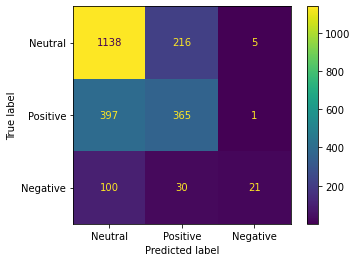

In [48]:
conmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
disp = ConfusionMatrixDisplay(conmat, display_labels = ['Neutral','Positive','Negative'])
disp.plot()

Our final accuracy score marked against the test data shows a slight dip in accuracy, indicating a possibilty of minor overfitting, but it's fairly minor.

More troublesome is the confusion matrix, and our poor f1-score on negative tweets. The fact of the matter is that negative tweets make up a fairly small section of the dataset. While the model overall beats baseline performance, it doesn't do as well on this micro scale. 

We could tweak the thresholds here, and try to pull in more of the lower left corner (that is, tweets that were negative that our model labeled neutral), but the trade off there would be an increase in the top or middle right columns (things our model flags as negative but is in fact neutral or positive). Further refinement might help there.

As is, the model does well enough to get the gist from a large dataset, and I would trust it to 

There are some ways to improve this model. It is possible that if we had more time to do hyperparameter tweaking or try different classifiers we might find a more suitable combination, but there is no guarentee. 

Additional preprocessing might help, although our gridsearches often found that the defaults worked very well. 

Additional human labeled data, especially of negative tweets, might help the model learn to classify that better.

Finally, this is a general model based on Apple and Google products. Our clients, if they existed, might want a more specific model based on tweets that were specifically about their product, which might pick up on domain/product specific praise or condemnation.